#### 주식 예측

- 파생변수 생성, XGBoost, 하이퍼파라미터 조정

In [1]:
import os
import pandas as pd
from tqdm import tqdm
# RSI : 상대강도지수(0~100)
# 금융 시장에서 주식이나 다른 자산의 과매수 또는 과매도 상태를 파악하기 위해 사용하는 기술
# 표준화를 안해도되서 RSI를 사용하는 것이 좋음

X = []
Y = []

window = 100

#LINE으로 보내기까지
for i in tqdm(os.listdir('/content/drive/MyDrive/iMbank_ML,DL실습/금융데이터분석/금융분석_1023/ETFs')):
    name = i.split('.')[0]
    df = pd.read_csv('/content/drive/MyDrive/iMbank_ML,DL실습/금융데이터분석/금융분석_1023/ETFs/' + i)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')

     # MACD 계산
    short_window = 12
    long_window = 26
    signal_window = 9

    df['EMA_Short'] = df['Close'].ewm(span=short_window, adjust=False).mean()
    df['EMA_Long'] = df['Close'].ewm(span=long_window, adjust=False).mean()
    df['MACD'] = df['EMA_Short'] - df['EMA_Long']


     # 스토캐스틱 오실레이터 계산
    df['K'] = (df['Close'] - df['Low'].rolling(window=14).min()) / (df['High'].rolling(window=14).max() - df['Low'].rolling(window=14).min()) * 100
    df['D'] = df['K'].rolling(window=3).mean()


    # print(df)

    data = df[['Change','RSI','MACD','D','Close']].values # 최대한 표준화된 데이터만 사용 Tip임 , valuse 사용하여 빠르게
    # print(data)

    for j in range(len(data) - window):
        try:
            a = data[j :j+window, :-1].flatten()
            b= int(data[j+window-1,-1]*1.02 < data[j+window, -1])

             # try 하는 이유 만약, 10개의 데이터 밖에 없다면 오류가 나기 때문

            #a = data.iloc[j : j + window][['Change','RSI']].to_numpy().flatten() # 문제집 만들기
            # flatten()은 2차원 배열을 1차원 배열로 변환하여, 데이터를 간편하게 다룰 수 있도록 하는 기능입니다.
            # print(a)
            #b = int(data.iloc[j+window -1]['Close'] * 1.05 < data.iloc[j + window]['Close'])# 문제집의 가장 마지막 값보다 5센트 종가가 올랐는게 정답지
            # j+window -1 문제집의 마지막 값의 가격의 5% 오른값보다 다음날 가격이 크다면
            #print(b)

        except:
            continue
        X.append(a)
        Y.append(b)


100%|██████████| 792/792 [00:41<00:00, 19.18it/s]


In [2]:
len(X),len(Y)

(842101, 842101)

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

# 학습/테스트 데이터 분리
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.25, random_state=42)

# 최적의 하이퍼파라미터로 모델 생성
best_params = {
    'max_depth': 4,
    'learning_rate': 0.2160523826326754,
    'n_estimators': 300,
    'min_child_weight': 2,
    'gamma': 0.6788404324817511,
    'subsample': 0.9242505996301495,
    'colsample_bytree': 0.876425335155132,
    'reg_alpha': 0.9069243453352921,
    'reg_lambda': 0.5586479973596679,
    'random_state': 857,
    # 'tree_method': 'gpu_hist'  # GPU 사용 설정
}

# XGBoost 모델 훈련
model = XGBClassifier(**best_params)
model.fit(train_x, train_y)

# 예측 및 성능 평가
pred = model.predict(test_x)
report = classification_report(test_y, pred)
print(report)


              precision    recall  f1-score   support

           0       0.96      1.00      0.98    200190
           1       0.80      0.16      0.26     10336

    accuracy                           0.96    210526
   macro avg       0.88      0.58      0.62    210526
weighted avg       0.95      0.96      0.94    210526



In [ ]:
model.fit(X,Y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.876425335155132, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.6788404324817511,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2160523826326754,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=857, ...)

In [ ]:
#LINE으로 보내기까지

total = []
for i in os.listdir('/content/drive/MyDrive/iMbank_ML,DL실습/금융데이터분석/금융분석_1023/ETFs'):
    name = i.split('.')[0]
    df = pd.read_csv('/content/drive/MyDrive/iMbank_ML,DL실습/금융데이터분석/금융분석_1023/ETFs/' + i)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')
    # print(df)

    data = df[['Change','RSI','MACD','D','Close']]
    today_data = data.iloc[-window:][['Change','RSI','MACD','D']].to_numpy().flatten()
    try:
        pred = model.predict_proba([today_data])[0][1]
        if pred > 0.7 :
            total.append([name,pred])
            #print(name)
    except:
        continue


KeyError: "['MACD', 'D'] not in index"

In [ ]:
total

In [ ]:
from datetime import datetime
today=str(datetime.today().date())

t = f'{today} 기준 종목 예측 \n\n'

for i in total:
    t +=f'추천종목 : {i[0]} ({i[1]:.2f})\n'

print(t)

#### 테스트 코드

In [ ]:
import os
import pandas as pd
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
import gc  # 가비지 컬렉션 사용

# 데이터 준비
X = []
Y = []
window = 150

# 데이터 일부 샘플링 및 메모리 절약을 위해 dtype 설정
for i in tqdm(os.listdir('/content/drive/MyDrive/iMbank_ML,DL실습/금융데이터분석/금융분석_1023/ETFs')):
    df = pd.read_csv('/content/drive/MyDrive/iMbank_ML,DL실습/금융데이터분석/금융분석_1023/ETFs/' + i,
                      dtype={'Open': np.float32, 'High': np.float32, 'Low': np.float32, 'Close': np.float32,
                             'Volume': np.float32, 'Change': np.float32, 'RSI': np.float32})
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')

    # 볼린져 밴드
    # df['Middle_Band'] = df['Close'].rolling(window=20).mean()
    # df['Upper_Band'] = df['Middle_Band'] + (df['Close'].rolling(window=20).std() * 2)
    # df['Lower_Band'] = df['Middle_Band'] - (df['Close'].rolling(window=20).std() * 2)

    # MACD 계산
    short_window = 12
    long_window = 26
    signal_window = 9

    df['EMA_Short'] = df['Close'].ewm(span=short_window, adjust=False).mean()
    df['EMA_Long'] = df['Close'].ewm(span=long_window, adjust=False).mean()
    df['MACD'] = df['EMA_Short'] - df['EMA_Long']
    # df['Signal_Line'] = df['MACD'].ewm(span=signal_window, adjust=False).mean()

    # 스토캐스틱 오실레이터 계산
    df['K'] = (df['Close'] - df['Low'].rolling(window=14).min()) / (df['High'].rolling(window=14).max() - df['Low'].rolling(window=14).min()) * 100
    df['D'] = df['K'].rolling(window=3).mean()


    # 변동성 지표

    period=14

    # True Range 계산
    # df['Previous_Close'] = df['Close'].shift(1)  # 이전 종가
    # df['High_Low'] = df['High'] - df['Low']  # 현재 고가 - 현재 저가
    # df['High_Previous_Close'] = abs(df['High'] - df['Previous_Close'])  # 현재 고가 - 이전 종가
    # df['Low_Previous_Close'] = abs(df['Low'] - df['Previous_Close'])  # 이전 종가 - 현재 저가

    # # TR 계산: TR은 위의 세 값 중 최대값
    # df['TR'] = df[['High_Low', 'High_Previous_Close', 'Low_Previous_Close']].max(axis=1)

    # # ATR 계산: TR의 이동 평균
    # df['ATR'] = df['TR'].rolling(window=period).mean()

    # # 불필요한 컬럼 제거
    # df.drop(columns=['Previous_Close', 'High_Low', 'High_Previous_Close', 'Low_Previous_Close', 'TR'], inplace=True)

    # print(df.tail())

    data = df[['Change','RSI','MACD','D','Close']].values # 볼린저 밴드, MACD, Signal_line, 스토오토캐스틱 변수 학습에 사용
    #

    for j in range(len(data) - window):
        try:
            a = data[j:j+window, :-1].flatten()
            b = int(data[j+window-1,-1] * 1.02 < data[j+window,-1])
        except:
            continue

        X.append(a)
        Y.append(b)

        # 일정량의 데이터만 처리하기 위해 샘플링 (ex: 10000개까지만 사용)
        if len(X) > 10000:
            break

    # 가비지 컬렉션을 사용해 메모리 확보
    gc.collect()

# 학습/테스트 데이터 분리
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.25, random_state=42)

# XGBoost 모델 훈련
model = XGBClassifier()
model.fit(train_x, train_y)

# 예측 및 성능 평가
pred = model.predict(test_x)
report = classification_report(test_y, pred)
print(report)

# 가비지 컬렉션 추가 호출
gc.collect()


100%|██████████| 792/792 [01:08<00:00, 11.56it/s]


              precision    recall  f1-score   support

           0       0.96      1.00      0.98      2567
           1       0.83      0.05      0.09       101

    accuracy                           0.96      2668
   macro avg       0.90      0.52      0.54      2668
weighted avg       0.96      0.96      0.95      2668



0

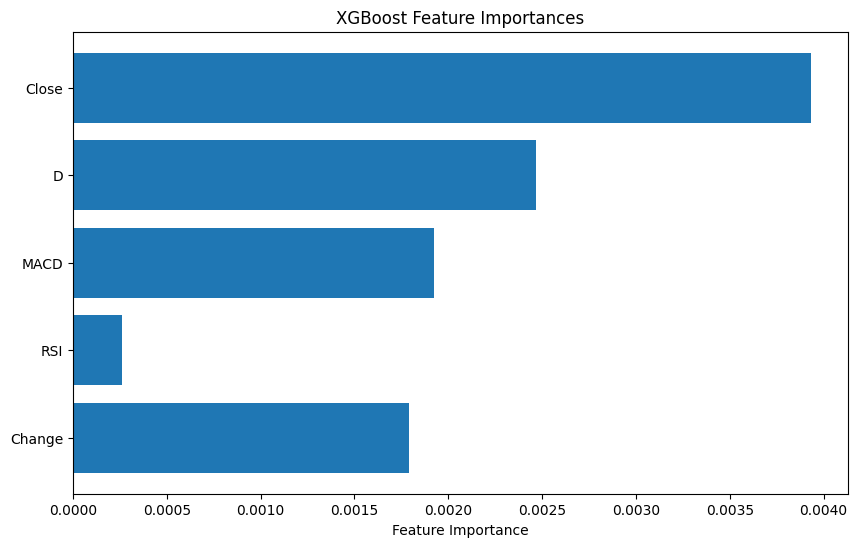

In [ ]:
import matplotlib.pyplot as plt

# 변수 중요도 추출 및 시각화
importances = model.feature_importances_

# 중요도 시각화를 위해 컬럼명 정의
column_names = ['Change','RSI','MACD','D','Close']

# 시각화
plt.figure(figsize=(10, 6))
plt.barh(column_names, importances[:len(column_names)])  # 상위 컬럼들의 중요도 시각화
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importances')
plt.show()

In [ ]:
!pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 66.4 MB/s eta 0:00:00
   

###### AutoML

In [ ]:
from pycaret.classification import *
import pandas as pd

# X와 Y를 DataFrame으로 변환
data_df = pd.DataFrame(X)
data_df['Close'] = Y  # 타겟 변수 추가

# 데이터의 30%만 샘플링
sample_df = data_df.sample(frac=0.3, random_state=42)

# PyCaret 설정
setup_clf = setup(data=sample_df, target='Close')

# 모델 비교
class_top = compare_models()
class_top


,Description,Value
0,Session id,696
1,Target,Close
2,Target type,Binary
3,Original data shape,"(3202, 601)"
4,Transformed data shape,"(3202, 601)"
5,Transformed train set shape,"(2241, 601)"
6,Transformed test set shape,"(961, 601)"
7,Numeric features,600
8,Rows with missing values,8.5%
9,Preprocess,True


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,08:13:20
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Gradient Boosting Classifier


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9630,0.8221,0.0000,0.0000,0.0000,0.0000,0.0000,4.5610
qda,Quadratic Discriminant Analysis,0.9630,0.5690,0.0000,0.0000,0.0000,0.0000,0.0000,0.4700
knn,K Neighbors Classifier,0.9603,0.6501,0.0375,0.2500,0.0644,0.0568,0.0871,0.3490
ridge,Ridge Classifier,0.9585,0.5897,0.0000,0.0000,0.0000,-0.0071,-0.0098,0.2040
ada,Ada Boost Classifier,0.9549,0.7098,0.0347,0.1700,0.0547,0.0396,0.0560,7.4070
dt,Decision Tree Classifier,0.9304,0.5451,0.1292,0.1149,0.1192,0.0837,0.0848,2.3700
svm,SVM - Linear Kernel,0.9219,0.6161,0.0722,0.0551,0.0616,0.0227,0.0229,0.2190
lr,Logistic Regression,0.8875,0.6153,0.0722,0.0308,0.0427,-0.0079,-0.0078,2.1220
nb,Naive Bayes,0.6760,0.7618,0.7250,0.0794,0.1430,0.0817,0.1595,0.3060


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
!pip install optuna xgboost scikit-learn

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.9 MB/s eta 0:00:00


In [ ]:
# 필요한 라이브러리 설치


# 필요한 라이브러리 임포트
import numpy as np
import optuna
from sklearn.datasets import make_moons  # 예제 데이터 생성
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

# 예제 데이터 생성
X, Y = make_moons(n_samples=500, noise=0.30, random_state=42)
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.25, random_state=42)

# Optuna로 사용할 목적 함수 정의
def objective(trial):
    # 하이퍼파라미터 정의
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'random_state': trial.suggest_int('random_state', 1, 1000)
    }

    # XGBoost 모델 정의 및 훈련
    model = XGBClassifier(**params)
    model.fit(train_x, train_y)

    # 예측 수행
    preds = model.predict(test_x)

    # 성능 평가 - F1 스코어를 목표로 설정
    f1_score = classification_report(test_y, preds, output_dict=True)['weighted avg']['f1-score']
    return f1_score

# Optuna 스터디 생성 및 최적화
study = optuna.create_study(direction='maximize')  # 목표: F1 스코어 최대화
study.optimize(objective, n_trials=100)  # 100회 탐색

# 최적 하이퍼파라미터 출력
print('Best parameters:', study.best_params)

# 최적의 하이퍼파라미터로 모델 재훈련 및 평가
best_model = XGBClassifier(**study.best_params)
best_model.fit(train_x, train_y)
best_preds = best_model.predict(test_x)

# 최종 성능 보고
final_report = classification_report(test_y, best_preds)
print(final_report)


[I 2024-10-23 07:49:45,076] A new study created in memory with name: no-name-04b818b5-4a01-4f03-bd2d-7fd263a6a271
[I 2024-10-23 07:49:45,139] Trial 0 finished with value: 0.8877128205128206 and parameters: {'max_depth': 7, 'learning_rate': 0.34770153918178576, 'n_estimators': 448, 'min_child_weight': 4, 'gamma': 0.37850148663953903, 'subsample': 0.9932117885816117, 'colsample_bytree': 0.38745418178076824, 'reg_alpha': 0.22570190633620088, 'reg_lambda': 0.7014589517275486, 'random_state': 891}. Best is trial 0 with value: 0.8877128205128206.
[I 2024-10-23 07:49:45,257] Trial 1 finished with value: 0.8075076923076923 and parameters: {'max_depth': 2, 'learning_rate': 0.3022130417474734, 'n_estimators': 689, 'min_child_weight': 6, 'gamma': 0.015140987536490472, 'subsample': 0.3582722497891831, 'colsample_bytree': 0.31864829470378253, 'reg_alpha': 0.11344818610397198, 'reg_lambda': 0.7734316392197881, 'random_state': 638}. Best is trial 0 with value: 0.8877128205128206.
[I 2024-10-23 07:49:

Best parameters: {'max_depth': 4, 'learning_rate': 0.2160523826326754, 'n_estimators': 837, 'min_child_weight': 2, 'gamma': 0.6788404324817511, 'subsample': 0.9242505996301495, 'colsample_bytree': 0.876425335155132, 'reg_alpha': 0.9069243453352921, 'reg_lambda': 0.5586479973596679, 'random_state': 857}
              precision    recall  f1-score   support

           0       0.89      0.93      0.91        61
           1       0.93      0.89      0.91        64

    accuracy                           0.91       125
   macro avg       0.91      0.91      0.91       125
weighted avg       0.91      0.91      0.91       125

